# Setup

In [1]:
%%capture
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import os
import scvi
import pandas as pd
import anndata as ad
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

In [2]:
sc.set_figure_params(figsize=(4,4),  dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

## Setup data paths

### demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Import data

In [6]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")
signatures = pd.read_csv("../../analysis/cell_type_signatures/merged_epithelium_fine_skin_signatures.csv", index_col=0, header=0)

## Methods

### cosine similarity

In [7]:
# adata must have log normalized counts in its raw attribute
# signatures must be a gene (row) by cell type (column) dataframe with average log normalized counts
def cell_type_cosine_similarity(adata, signatures, scale=True, label="cosine_similarity"):
    # Raw attribute contains the log-normalized counts
    cell_data = pd.DataFrame(adata.raw.X.toarray(), columns=adata.raw.var_names, index=adata.obs.index).T
    cell_data = cell_data[cell_data.index.isin(adata.var_names)]
    cell_data = cell_data / cell_data.sum(axis=0) # Normalize per cell expression to sum to 1
    all_df = cell_data.join(signatures, how="inner") # Join with gene x cell type signature matrix so that only shared genes are kept
    all_df = all_df / all_df.sum(axis=0) # Normalize per cell expression to sum to 1
    print(f"Number of genes used for cosine similarity calculations: {len(all_df)}")
    # Calculate cosine similarity of single cells to each cell type
    sim = cosine_similarity(
        all_df[all_df.columns[:cell_data.shape[1]]].values.T, # Single-cell expression data
        all_df[all_df.columns[cell_data.shape[1]:]].values.T # Cell type gene signature expression data
    )

    # Create dataframe with per cell similarity scores for each cell type
    similarity = pd.DataFrame(
        sim, 
        columns=all_df.columns[cell_data.shape[1]:],
        index=all_df.columns[:cell_data.shape[1]]
    )
    if scale:
        # Scale similarity scores by cell
        scaler = StandardScaler()
        minmax_scale = scaler.fit(similarity.T)
        x_minmax = minmax_scale.transform(similarity.T).T
        scale_by_row = pd.DataFrame(x_minmax)
        
        # Add cosine similarity scores to adata obs
        scale_by_row.index = similarity.index
        scale_by_row.columns = similarity.columns + "_" + label
        adata.obs = adata.obs.join(scale_by_row)
    else:
        similarity.columns = similarity.columns + "_" + label
        adata.obs = adata.obs.join(similarity)
    
    return adata

### cosine similarity gene contribution

In [8]:
def gene_similarity_score_contribution(adata, signature_matrix, signatures):
    gene_similarity_scores = pd.DataFrame()
    genes = signature_matrix[signature_matrix.index.isin(adata.var_names)].index
    print(f"Using {len(genes)} genes")
    for signature in signatures:
        cell_data = pd.DataFrame(adata.raw.X.toarray(), columns=adata.raw.var_names, index=adata.obs.index).T
        cell_data = cell_data[cell_data.index.isin(genes)]
        
        signature_data = pd.DataFrame(signature_matrix[signature])
        signature_data = signature_data[signature_data.index.isin(genes)]
        signature_data = signature_data[signature]
        cell_data_norms = np.sqrt((cell_data**2).sum(axis=0))
        cell_data = cell_data.mul(signature_data, axis=0)
        cell_data = cell_data.div(cell_data_norms, axis=1)
        gene_similarity_scores[signature + "_similarity_contribution"] = cell_data.mean(axis=1)
    return gene_similarity_scores

# Recluster post-Aire cells

In [9]:
#Subset on highly variable genes
sc.pp.highly_variable_genes(
    adata,
    layer="counts",
    n_top_genes=7500,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True,
)

In [10]:
"Malat1" in adata.var_names

True

In [11]:
postAireAdata = adata[
    (adata.obs.genotype == "WT") &
    adata.obs.cell_type.isin(["PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"])
]

In [12]:
sc.pp.neighbors(postAireAdata, use_rep="X_scVI")
sc.tl.umap(postAireAdata)

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


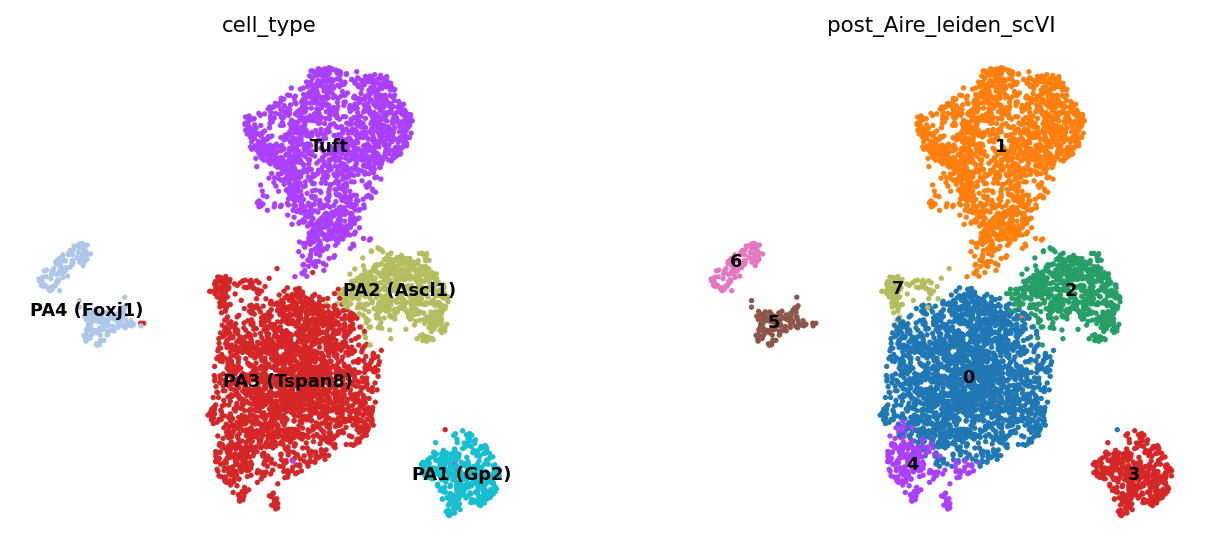

In [13]:
sc.tl.leiden(postAireAdata, key_added="post_Aire_leiden_scVI", resolution=0.3)
sc.settings.figdir = "../../analysis/Paper figs/3 (M cells)"
sc.pl.umap(
    postAireAdata,
    color=["cell_type", "post_Aire_leiden_scVI",],
    legend_loc="on data",
    legend_fontsize="small",
    save="_3A_post_aire_reclustering.pdf"
)

# Cosine similarity

## epithelial signatures

In [14]:
postAireAdata = cell_type_cosine_similarity(postAireAdata, signatures, label="epithelial_similarity")

Number of genes used for cosine similarity calculations: 2951


In [15]:
epithelialSimilarities = [i for i in postAireAdata.obs.columns if "epithelial_similarity" in i]
epithelialSimilarities.sort()
epithelialSimilarities

['ANA.-.8_skin.fine_epithelial_similarity',
 'Acinar/Ductal_pancreatic_epithelial_similarity',
 'Acinar_pancreatic_epithelial_similarity',
 'Acinar_salivary_gland_epithelial_similarity',
 'Ascl3+.duct_salivary_gland_epithelial_similarity',
 'Basal.duct_salivary_gland_epithelial_similarity',
 'Basal_respiratory_epithelial_similarity',
 'Bpifa2+_salivary_gland_epithelial_similarity',
 'CX1_skin.fine_epithelial_similarity',
 'CX2_skin.fine_epithelial_similarity',
 'CX3_skin.fine_epithelial_similarity',
 'CX4_skin.fine_epithelial_similarity',
 'CX5_skin.fine_epithelial_similarity',
 'Ciliated_respiratory_epithelial_similarity',
 'Club_respiratory_epithelial_similarity',
 'DC_skin.fine_epithelial_similarity',
 'DS1_skin.fine_epithelial_similarity',
 'DS2_skin.fine_epithelial_similarity',
 'Ductal/Acinar_pancreatic_epithelial_similarity',
 'Ductal_pancreatic_epithelial_similarity',
 'EC1_skin.fine_epithelial_similarity',
 'EC2_skin.fine_epithelial_similarity',
 'Endocrine-Ngn3_pancreatic_epi

## Plotting

### selected signatures UMAPs

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


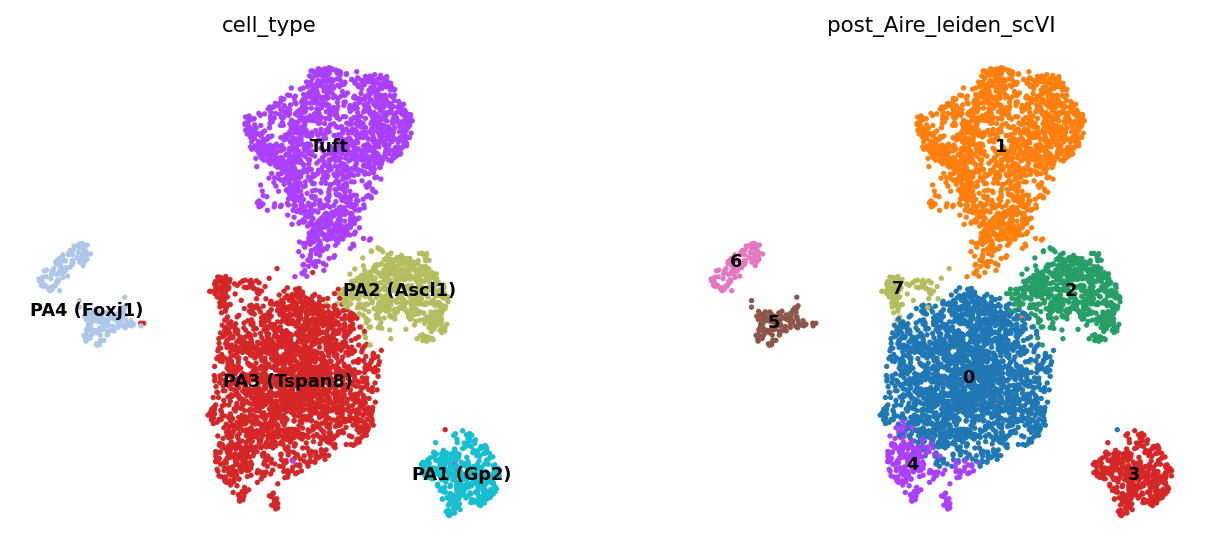

In [16]:
sc.settings.figdir = "../../analysis/Paper figs/S4 (cosine similarity)"
sc.pl.umap(
    postAireAdata,
    color=["cell_type", "post_Aire_leiden_scVI",],
    legend_loc="on data",
    legend_fontsize="small",
    save="_S4A_post_aire_reclustering.pdf"
)

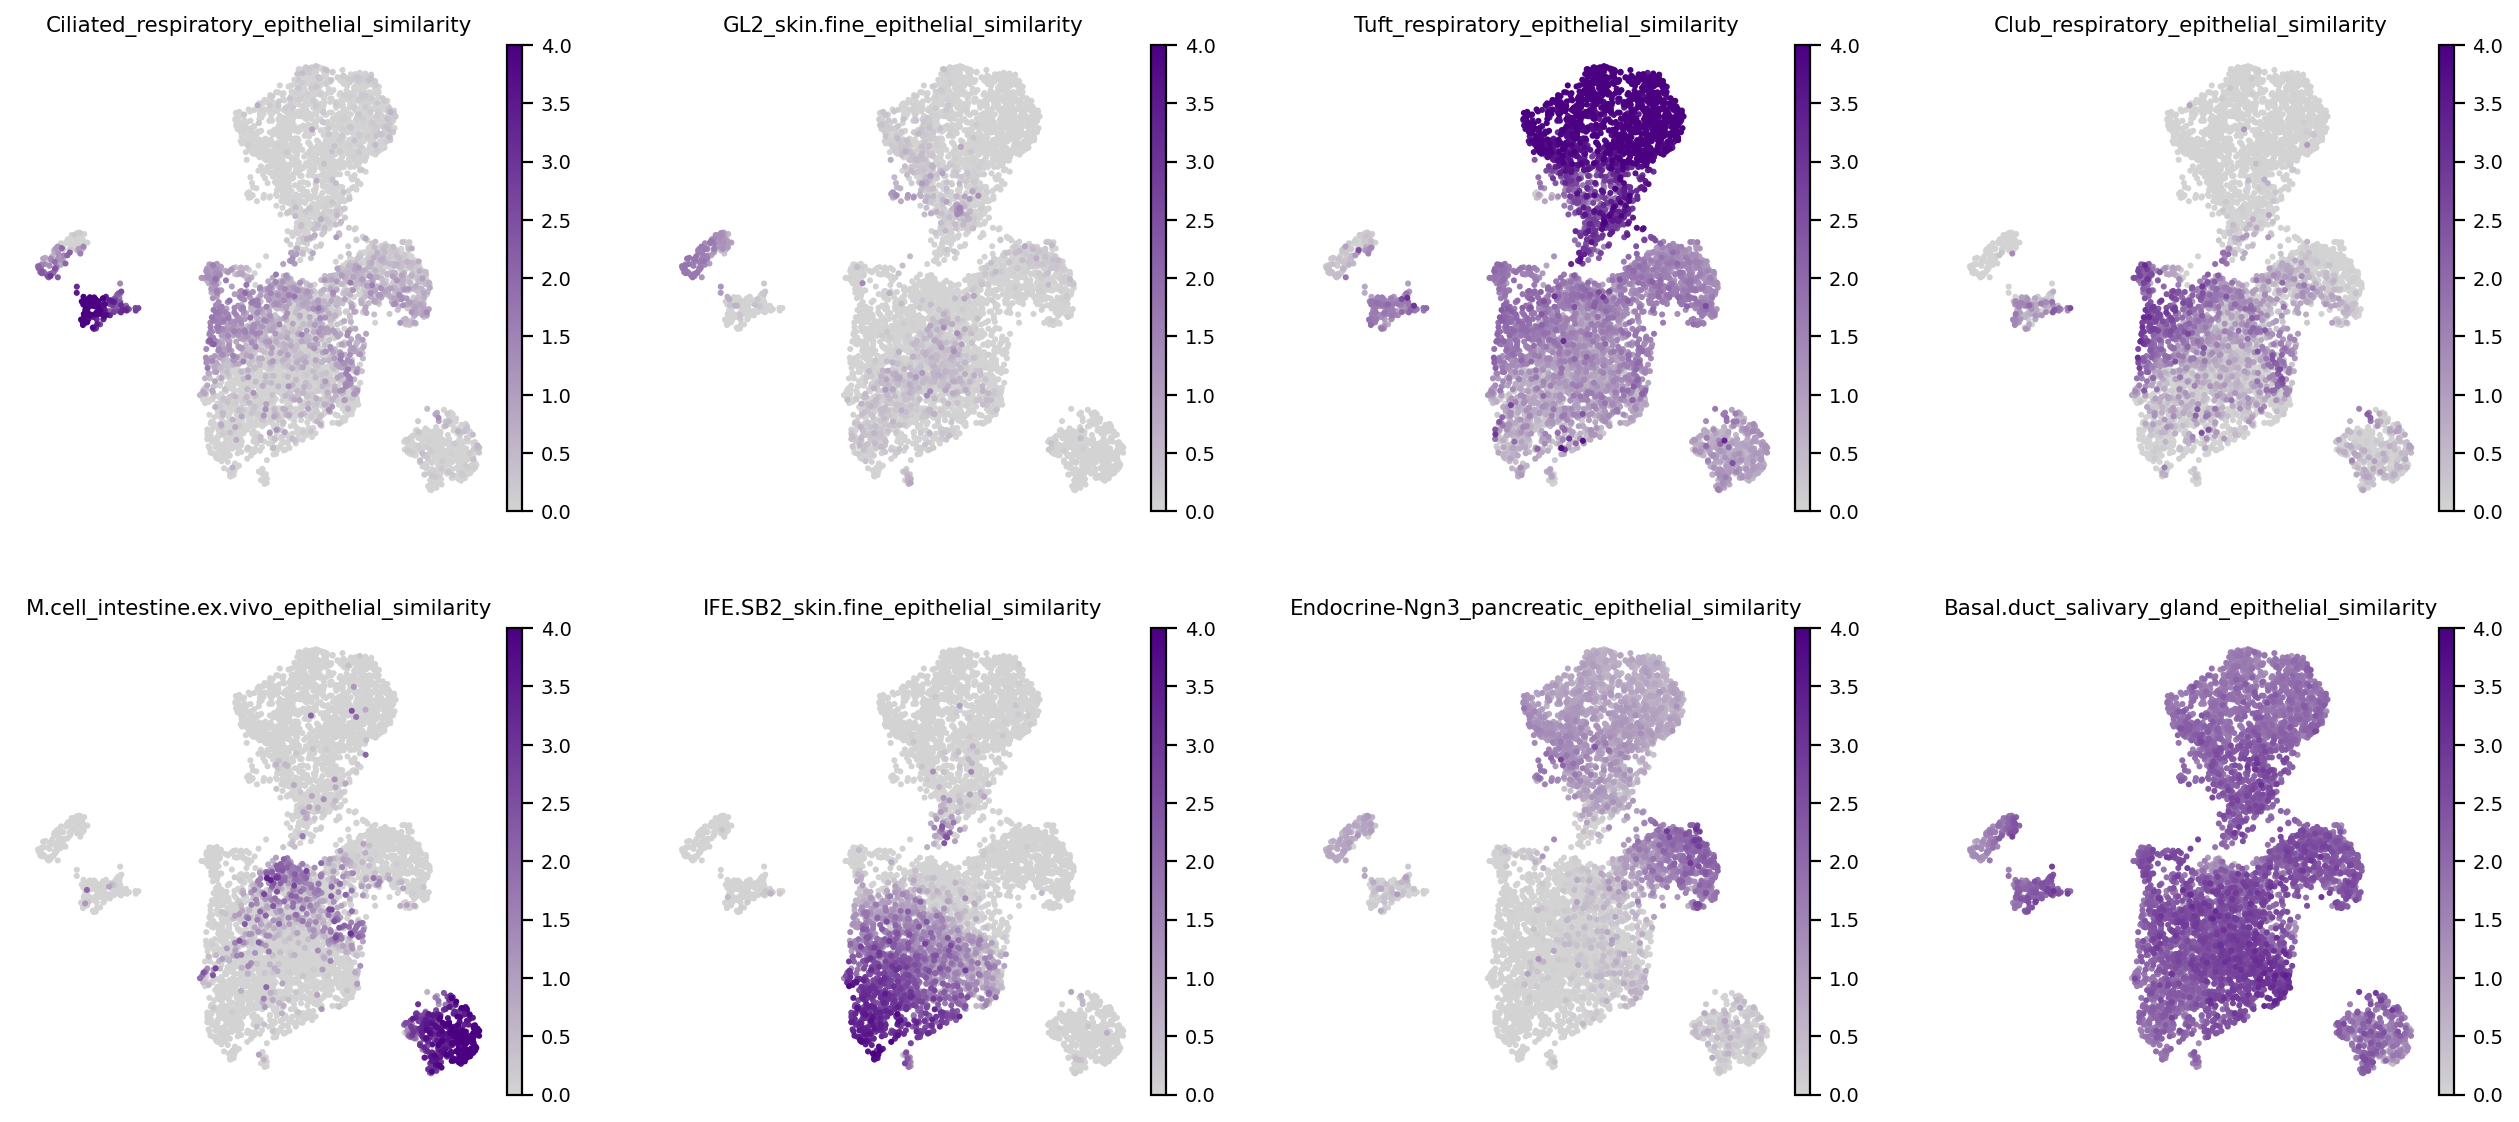

In [17]:
scores = [
    "Ciliated_respiratory_epithelial_similarity",
    "GL2_skin.fine_epithelial_similarity",
    "Tuft_respiratory_epithelial_similarity",
    "Club_respiratory_epithelial_similarity",
    "M.cell_intestine.ex.vivo_epithelial_similarity",
    'IFE.SB2_skin.fine_epithelial_similarity',
    'Endocrine-Ngn3_pancreatic_epithelial_similarity',
    'Basal.duct_salivary_gland_epithelial_similarity'
]
colors = ["lightgrey", "indigo"]
colormap = LinearSegmentedColormap.from_list("GyPl", colors)
sc.settings.figdir = "../../analysis/Paper figs/S4 (cosine similarity)"
sc.pl.umap(
    postAireAdata,
    color=scores,
    legend_loc="on data",
    legend_fontsize="xx-small",
    cmap=colormap,
    vmin=0,
    vmax=4,
    s=30,
    save="_S4C_selected_signature_UMAPs.pdf"
)

### all signatures heatmap

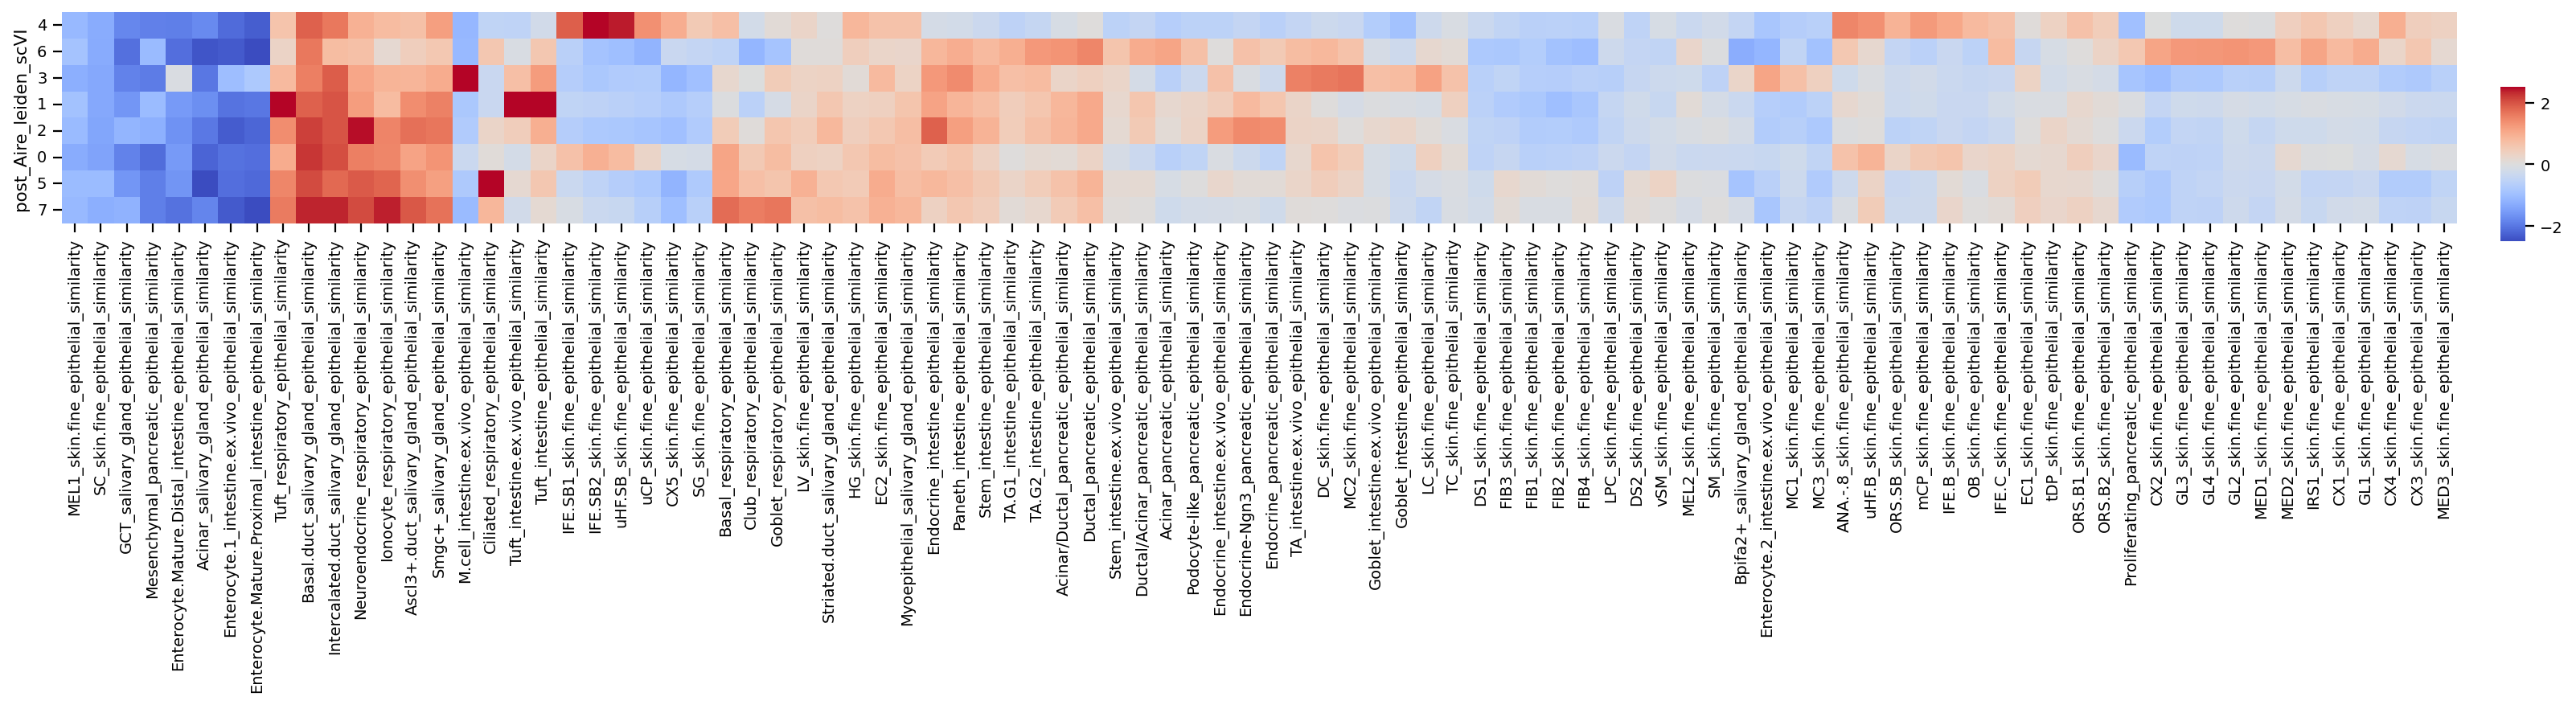

In [18]:
data = postAireAdata.obs.groupby("post_Aire_leiden_scVI").mean()[epithelialSimilarities]
cg = sns.clustermap(
    data,
    cmap="coolwarm",
    figsize=(24,6),
    xticklabels=True,
    vmin=-2.5,
    vmax=2.5,
)
cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), rotation=0)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.yaxis.set_label_position("left")
cg.ax_cbar.set_position([0.99, 0.61, 0.008, 0.2])
plt.savefig(
    "../../analysis/Paper figs/S4 (cosine similarity)/S4B_cosine_similarity_heatmap.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

### selected signatures heatmap

In [19]:
similarityScoreData = postAireAdata.obs[epithelialSimilarities].copy()
similarityScoreData["post_Aire_leiden_scVI"] = postAireAdata.obs["post_Aire_leiden_scVI"].copy()
similarityScoreData = similarityScoreData.groupby("post_Aire_leiden_scVI").mean()

In [20]:
selectedScores = list(similarityScoreData.T[similarityScoreData.max() - similarityScoreData.median() > 1].index)

In [21]:
selectedScores

['ANA.-.8_skin.fine_epithelial_similarity',
 'Acinar_pancreatic_epithelial_similarity',
 'Basal_respiratory_epithelial_similarity',
 'CX2_skin.fine_epithelial_similarity',
 'CX4_skin.fine_epithelial_similarity',
 'CX5_skin.fine_epithelial_similarity',
 'Ciliated_respiratory_epithelial_similarity',
 'Club_respiratory_epithelial_similarity',
 'DC_skin.fine_epithelial_similarity',
 'Endocrine-Ngn3_pancreatic_epithelial_similarity',
 'Endocrine_intestine.ex.vivo_epithelial_similarity',
 'Endocrine_intestine_epithelial_similarity',
 'Endocrine_pancreatic_epithelial_similarity',
 'Enterocyte.1_intestine.ex.vivo_epithelial_similarity',
 'Enterocyte.2_intestine.ex.vivo_epithelial_similarity',
 'Enterocyte.Mature.Distal_intestine_epithelial_similarity',
 'Enterocyte.Mature.Proximal_intestine_epithelial_similarity',
 'GL1_skin.fine_epithelial_similarity',
 'GL2_skin.fine_epithelial_similarity',
 'GL3_skin.fine_epithelial_similarity',
 'GL4_skin.fine_epithelial_similarity',
 'Goblet_intestine_epi

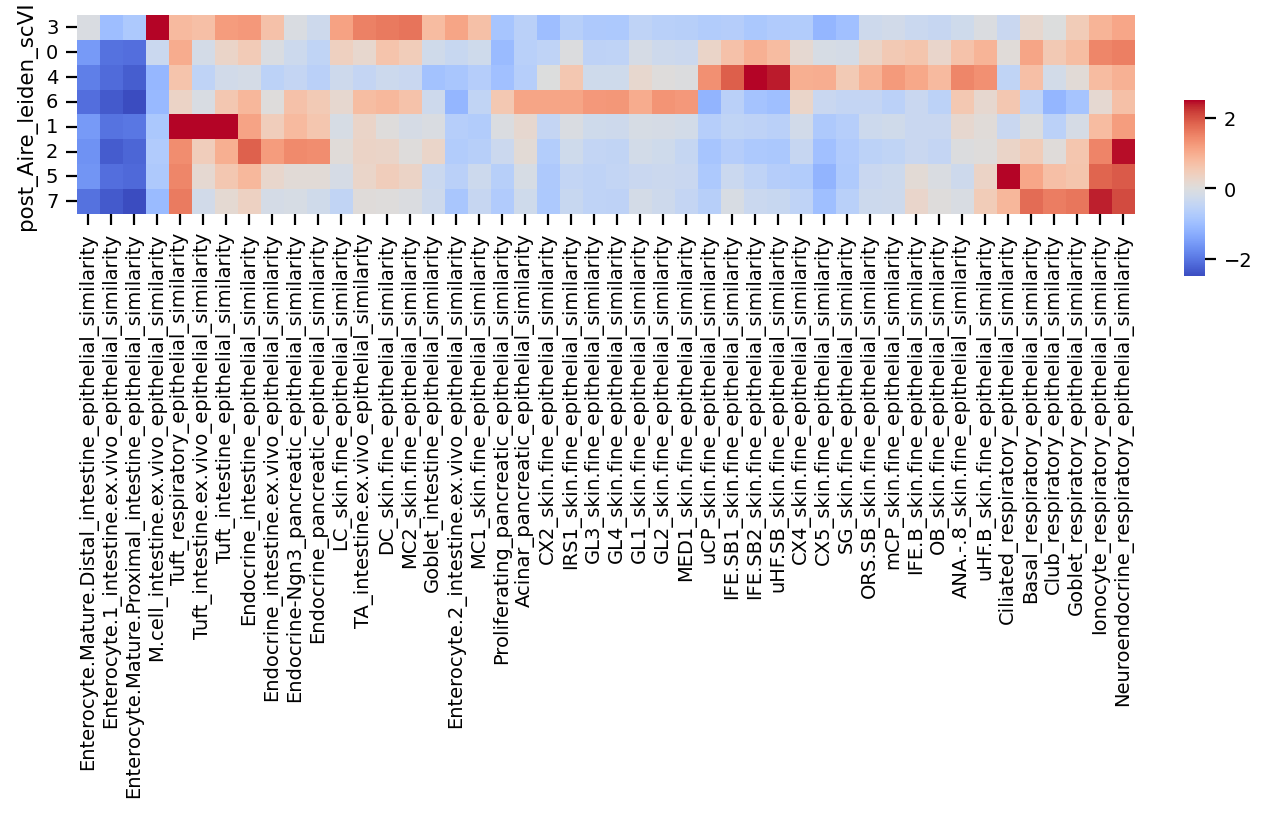

In [26]:
data = postAireAdata.obs.groupby("post_Aire_leiden_scVI").mean()[selectedScores]
cg = sns.clustermap(
    data,
    cmap="coolwarm",
    figsize=(9,5.5),
    xticklabels=True,
    vmin=-2.5,
    vmax=2.5,
)
cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), rotation=0)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.yaxis.set_label_position("left")
cg.ax_cbar.set_position([0.97, 0.62, 0.015, 0.2])
plt.savefig(
    "../../analysis/Paper figs/3 (M cells)/3B_cosine_similarity_heatmap.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

# Signature contributing genes

In [23]:
scores = [
    "Ciliated_respiratory",
    "GL2_skin.fine",
    "Tuft_respiratory",
    "Club_respiratory",
    "M.cell_intestine.ex.vivo",
    'IFE.SB2_skin.fine',
    'Endocrine-Ngn3_pancreatic',
]

similarityGeneScores = gene_similarity_score_contribution(
    postAireAdata,
    signatures,
    scores

)

Using 2951 genes


In [24]:
genes = []
for signature in similarityGeneScores:
    sortedData = similarityGeneScores.sort_values(by=signature, ascending=False)
    for i in sortedData.head(50).index:
        genes.append(i)
geneList = list(set(genes))

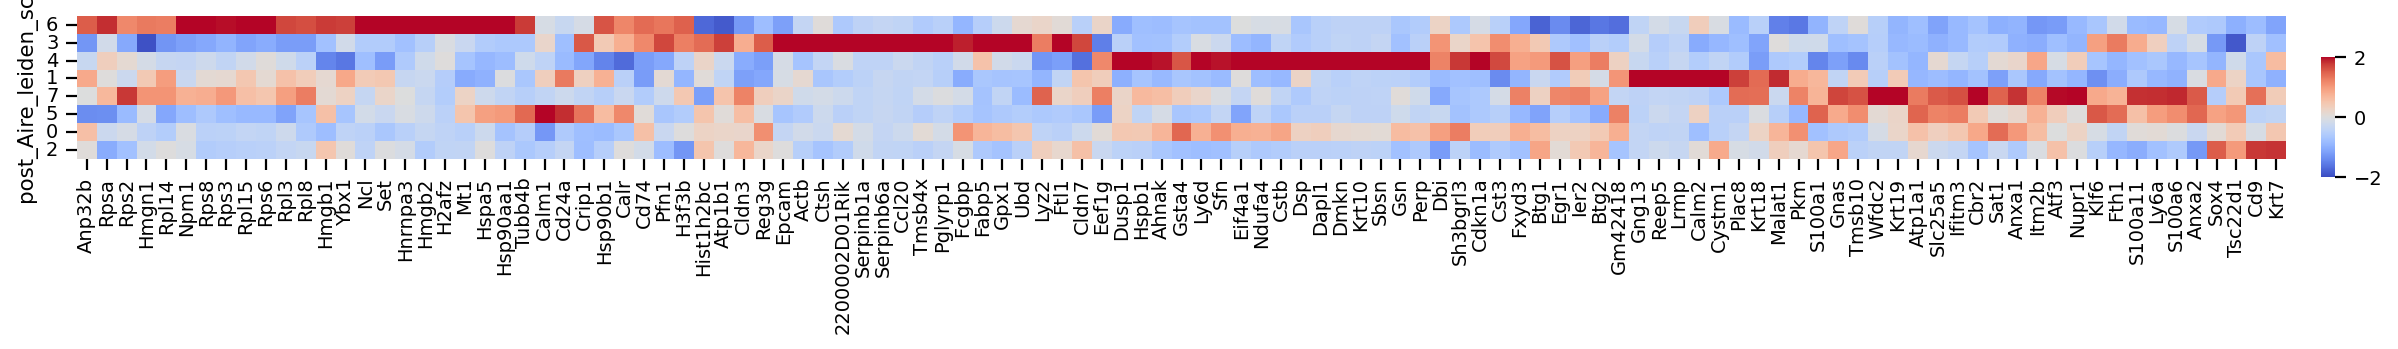

In [25]:
data = pd.DataFrame(
    postAireAdata[:, geneList].layers["scVI_normalized"],
    index=postAireAdata.obs.index,
    columns=postAireAdata[:, geneList].var_names
)
data["post_Aire_leiden_scVI"] = postAireAdata.obs.post_Aire_leiden_scVI
data = data.groupby("post_Aire_leiden_scVI").mean()
cg = sns.clustermap(
    data,
    cmap="coolwarm",
    figsize=(18,2.5),
    xticklabels=True,
    #standard_scale=1,
    z_score=1,
    vmin=-2,
    vmax=2
)
cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), rotation=0)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.yaxis.set_label_position("left")
cg.ax_cbar.set_position([0.98, 0.45, 0.005, 0.3])
plt.savefig(
    "../../analysis/Paper figs/S4 (cosine similarity)/S4D_contributing_genes_heatmap.pdf",
    bbox_inches="tight",
    dpi=300
)
plt.show()